In [1]:
# импортируем нужные библиотеки
from rdkit import Chem
from rdkit.Chem import Recap
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Geometry import Point3D
from scipy.spatial.transform import Rotation as R
import numpy as np
import collections
import random
import pandas as pd
import matplotlib.pyplot as plt
IPythonConsole.ipython_useSVG=True 
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 300,300
debug = True

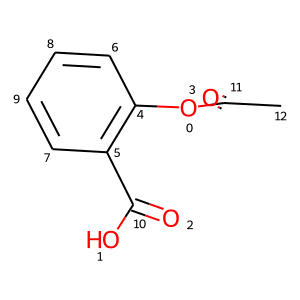

In [2]:
# парсим данные из молекулы
molecule = Chem.MolFromMolFile("Conformer3D_CID_2244.sdf")
molecule = Chem.rdmolops.RemoveAllHs(molecule)
molecule

In [3]:
def get_coordinates(molecule):
    """Берем координаты из молекулы"""
    conf = molecule.GetConformer()
    for atom in molecule.GetAtoms():
        idx = atom.GetIdx()
        position = conf.GetAtomPosition(idx)
        if idx == 0:
            coord = np.array([[position.x, position.y, position.z]])
        else:
            coord = np.append(coord, [[position.x, position.y, position.z]], axis=0)
    return coord
old_coordinates = get_coordinates(molecule)
old_coordinates

array([[ 1.2333,  0.554 ,  0.7792],
       [-0.6952, -2.7148, -0.7502],
       [ 0.7958, -2.1843,  0.8685],
       [ 1.7813,  0.8105, -1.4821],
       [-0.0857,  0.6088,  0.4403],
       [-0.7927, -0.5515,  0.1244],
       [-0.7288,  1.8464,  0.4133],
       [-2.1426, -0.4741, -0.2184],
       [-2.0787,  1.9238,  0.0706],
       [-2.7855,  0.7636, -0.2453],
       [-0.1409, -1.8536,  0.1477],
       [ 2.1094,  0.6715, -0.3113],
       [ 3.5305,  0.5996,  0.1635]])

In [4]:
def copy_mol(molecule1, molecule2):
    """molecule1 - откуда берем координаты, molecule2 - что изменяем"""
    conf1 = molecule1.GetConformer()
    conf2 = molecule2.GetConformer()
    for atom in molecule1.GetAtoms():
        idx = atom.GetIdx()
        position = conf1.GetAtomPosition(idx)
        conf2.SetAtomPosition(idx, Point3D(position.x, position.y, position.z))

In [5]:
Chem.Draw.IPythonConsole.drawMol3D(molecule)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [6]:
def find_bonds(molecule):
    """Находим правильные рёбра"""
    leaf_atoms = [atom.GetIdx() for atom in molecule.GetAtoms() if atom.GetDegree() == 1]
    bonds_pos = []
    for bond in molecule.GetBonds():
        is_atoms_leaf = bond.GetBeginAtomIdx() in leaf_atoms or bond.GetEndAtomIdx() in leaf_atoms
        if bond.GetBondTypeAsDouble() == 1.0 and bond.IsInRing() == False and not is_atoms_leaf:
            conf = molecule.GetConformer()
            begin_ind = bond.GetBeginAtomIdx()
            finish_ind = bond.GetEndAtomIdx()
            positions_start, positions_end = conf.GetAtomPosition(begin_ind), conf.GetAtomPosition(finish_ind)
            bonds_pos.append([begin_ind, finish_ind])
    return bonds_pos

In [7]:
def bfs(m, root, stop_vertex):
    """Обход в глубину m - молекула, root - начало, stop_vertex - конец"""
    visited, queue = set(), collections.deque([root])
    visited.add(root)
    prev_vertex = stop_vertex
    while queue:
        vertex = queue.popleft()
        atom = m.GetAtomWithIdx(vertex)
        for neighbour in atom.GetNeighbors():
            index_neighbour = neighbour.GetIdx()
            if index_neighbour == stop_vertex:
                continue
            if index_neighbour not in visited:
                visited.add(index_neighbour)
                queue.append(index_neighbour)       
    visited.remove(root)
    return visited

In [8]:
def random_degrees(n=1):
    """Генерация случайных углов"""
    return [round(random.uniform(0, 360), 2) for _ in range(n)]

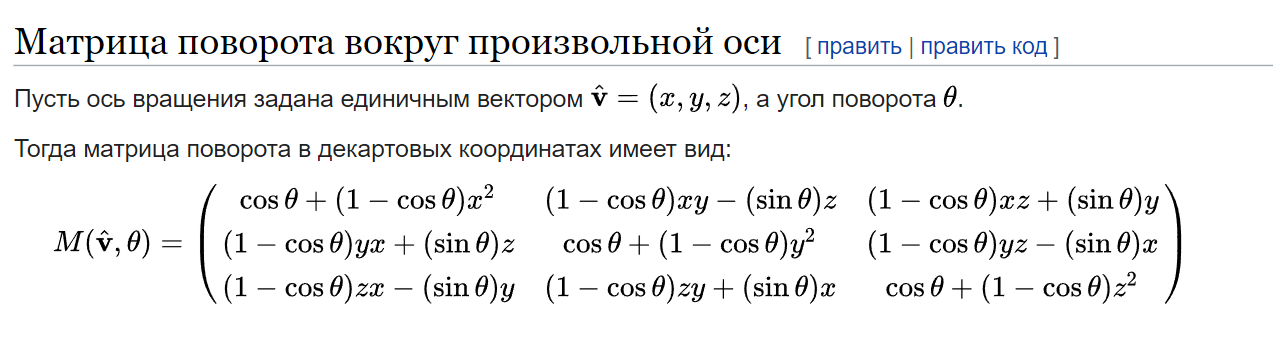

In [9]:
def rotate(molecule, A, B, V, degrees):
    """А - что вращаем, V - смещение координат,
    B - вектор, вокруг котороо вращаем,
    degrees - угол вращения (градусы -> радианы)"""
    conf = molecule.GetConformer()
    theta = np.radians(degrees)
    position_V = conf.GetAtomPosition(V)
    position_B = conf.GetAtomPosition(B)
    T = np.array([[1, 0, 0, 0],  # матрица смещения
                 [0, 1, 0, 0],
                 [0, 0, 1, 0],
                 [position_V.x, position_V.y, position_V.z, 1]])
    V = np.array([position_B.x - position_V.x, 
                  position_B.y - position_V.y, 
                  position_B.z - position_V.z])
    x, y, z = V / np.linalg.norm(V)
    M = np.array([[np.cos(theta) + (1 - np.cos(theta)) * (x ** 2), (1 - np.cos(theta))*x*y - np.sin(theta)*z, (1 - np.cos(theta))*x*z + np.sin(theta) * y],
                [(1 - np.cos(theta))*y*x + np.sin(theta) * z, np.cos(theta) + (1 - np.cos(theta))*(y ** 2), (1 - np.cos(theta))*y*z - np.sin(theta)*x],
                [(1 - np.cos(theta))*z*x - np.sin(theta)*y, (1 - np.cos(theta))*z*y + np.sin(theta)*x, np.cos(theta) + (1 - np.cos(theta))*(z ** 2)]])
    M_star = np.append(M, [[0, 0, 0]], axis=0)
    M_star = np.append(M_star, np.array([0, 0, 0, 1]).reshape(4, 1), axis=1)
    M_gen = np.linalg.inv(T)@M_star@T

    for vertex in A:
        position = conf.GetAtomPosition(vertex)
        res = np.array([position.x, position.y, position.z, 1])@M_gen
        conf.SetAtomPosition(vertex, Point3D(res[0], res[1], res[2]))

In [10]:
def rotate_graph(m, bonds, degrees, is_reverse):
    """Вращение графа, m - молекула, bonds - нужные связи в молекуле, вокруг которых мы поворачиваем вершины,
    degrees - список углов (в градусах) - на какой угол поворачиваем рёбра"""
    if is_reverse is True:
        bonds = list(reversed(bonds))
        degrees = list(reversed(degrees))
    for ind, bond in enumerate(bonds):
        root, stop = bond
        vertexes = bfs(m, root, stop)
        rotate(m, vertexes, root, stop, degrees[ind])

In [11]:
def rotate_derivative(molecule, A, B, V, degrees):
    """А - что вращаем, V - смещение координат,
    B - вектор, вокруг котороо вращаем,
    degrees - угол вращения (градусы -> радианы)"""
    conf = molecule.GetConformer()
    position_V = conf.GetAtomPosition(V)
    position_B = conf.GetAtomPosition(B)
    T = np.array([[1, 0, 0, 0],  # матрица смещения
                 [0, 1, 0, 0],
                 [0, 0, 1, 0],
                 [position_V.x, position_V.y, position_V.z, 1]])
    V = np.array([position_B.x - position_V.x, 
                  position_B.y - position_V.y, 
                  position_B.z - position_V.z])
    x, y, z = V / np.linalg.norm(V)
    
    theta = np.radians(degrees)
    M_gen_derivative = np.array([[(x ** 2 - 1) * np.sin(theta), np.sin(theta) * x * y - np.cos(theta) * z, np.sin(theta) * x * z + np.cos(theta) * y, 0],
                                [np.sin(theta) * y * x + np.cos(theta) * z, np.sin(theta) * (y ** 2 - 1), np.sin(theta) * y * z - np.cos(theta) * x, 0],
                                [np.sin(theta) * z * x - np.cos(theta) * y, np.sin(theta) * z * y + np.cos(theta) * x, np.sin(theta)* (z ** 2 - 1), 0],
                                [position_V.x * np.sin(theta) + np.cos(theta)*(position_V.z*y-position_V.y*z) + np.sin(theta)*(-position_V.x * x * x - position_V.y * y * x - position_V.z * z * x), 
                                 np.cos(theta)*(position_V.x*z - position_V.z * x) + np.sin(theta) * position_V.y + np.sin(theta) * (-position_V.x * x * y - position_V.y * y * y - position_V.z * y * z), 
                                 np.cos(theta)*(position_V.y * x - position_V.x * y) + np.sin(theta) * position_V.z + np.sin(theta) * (-position_V.x * x * z - position_V.y * y * z - position_V.z * z * z), 
                                 0]])
    for vertex in A:
        position = conf.GetAtomPosition(vertex)
        res = np.array([position.x, position.y, position.z, 1])@M_gen_derivative
        conf.SetAtomPosition(vertex, Point3D(res[0], res[1], res[2]))
        
        
def rotate_graph_derivative(m, bonds, degrees, is_reverse):
    """Вращение графа, m - молекула, bonds - нужные связи в молекуле, вокруг которых мы поворачиваем вершины,
    degrees - список углов (в градусах) - на какой угол поворачиваем рёбра"""
    if is_reverse is True:
        bonds = list(reversed(bonds))
        degrees = list(reversed(degrees))
    for ind, bond in enumerate(bonds):
        root, stop = bond
        vertexes = bfs(m, root, stop)
        if degrees[ind] != 0:
            rotate_derivative(m, vertexes, root, stop, degrees[ind])

In [12]:
# molecule = Chem.MolFromMolFile("Conformer3D_CID_2244.sdf")
# molecule = Chem.rdmolops.RemoveAllHs(molecule)
bonds = find_bonds(molecule)
degrees = random_degrees(len(bonds))   
rotate_graph(molecule, bonds, degrees, False)
# coordinates_after_rotation = get_coordinates(molecule)
Chem.Draw.IPythonConsole.drawMol3D(molecule)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [13]:
def create_buffers_mol(n=3):
    """Создание буферных молекул"""
    molecule_after_r = Chem.MolFromMolFile("Conformer3D_CID_2244.sdf")
    molecule_after_r = Chem.rdmolops.RemoveAllHs(molecule_after_r)
    copy_mol(molecule, molecule_after_r)
    buffer_mols = []
    derivative_mols = []
    for i in range(n):
        buf_mol = Chem.MolFromMolFile("Conformer3D_CID_2244.sdf")
        buf_mol = Chem.rdmolops.RemoveAllHs(buf_mol)
        copy_mol(molecule, buf_mol)
        buffer_mols.append(buf_mol)
        derivative_mol = Chem.MolFromMolFile("Conformer3D_CID_2244.sdf")
        derivative_mol = Chem.rdmolops.RemoveAllHs(derivative_mol)
        copy_mol(molecule, derivative_mol)
        derivative_mols.append(derivative_mol)
    return molecule_after_r, buffer_mols, derivative_mols

In [14]:
def find_df_theta(mol, old_coordinates, coord, new_coordinates_random, bonds, index):
    """Функция для нахождения df/dtheta"""
    root, stop = bonds[index]
    vertexes = bfs(mol, root, stop)
    sum_err = 0
    for ind in vertexes:
        sum_err = sum_err + (2*(old_coordinates[ind] - coord[ind]) * new_coordinates_random[ind]).sum()
    return sum_err

In [15]:
def gradient(bonds):
    """Градиентный спуск"""
    eps = 2
    sum_error = eps + 1
    sum_errors = []
    count_bonds = len(bonds)
    molecule_after_r, buf_mols, derivative_mols = create_buffers_mol(count_bonds)
    h = 0.01
    new_degrees = random_degrees(count_bonds)
    if debug is True:
        print("новые рандомные углы: {}".format(new_degrees))
        print("рандомные углы, которые мы забываем: {}".format(degrees))
    N = 3000
    while sum_error >= eps and N > 0:
        for i in range(count_bonds - 1, -1, -1):
            copy_mol(molecule_after_r, molecule)
            if i == count_bonds - 1:
                copy_mol(molecule_after_r, buf_mols[i])
                copy_mol(molecule_after_r, derivative_mols[i])
            else:
                copy_mol(buf_mols[i+1], buf_mols[i])
                copy_mol(buf_mols[i+1], derivative_mols[i])
            
            one_angle_list = [0] * count_bonds
            one_angle_list[i] = -new_degrees[i]
            
            rotate_graph(buf_mols[i], bonds, one_angle_list, True)     
            coordinates_after_rotation_random_angle = get_coordinates(buf_mols[i])
            
            rotate_graph_derivative(derivative_mols[i], bonds, one_angle_list, True)
            new_coordinates_random = get_coordinates(derivative_mols[i])
            
            df_theta = find_df_theta(molecule, old_coordinates, coordinates_after_rotation_random_angle, new_coordinates_random, bonds, i)
            new_degrees[i] = (new_degrees[i] - h * df_theta) % 360
            one_angle_list[i] = -new_degrees[i]
            rotate_graph(molecule, bonds, one_angle_list, True)
            
        copy_mol(molecule_after_r, molecule)
        degrees_minus = list(map(lambda x: -x, new_degrees))
        rotate_graph(molecule, bonds, degrees_minus, True) 
        coord = get_coordinates(molecule)
        sum_error = ((old_coordinates - coord) ** 2).sum()
        sum_errors.append(sum_error)
        N -= 1
    
    copy_mol(molecule_after_r, molecule)
    degrees_minus = list(map(lambda x: -x, new_degrees))
    rotate_graph(molecule, bonds, degrees_minus, True) 
    coord = get_coordinates(molecule)
    if debug is True:
        print("новые углы: {}".format(new_degrees))
        # print("sum err: {}".format(((old_coordinates - coord) ** 2).sum()))
    return sum_errors

errors = np.array(gradient(bonds), dtype='float')
Chem.Draw.IPythonConsole.drawMol3D(molecule)

новые рандомные углы: [350.98, 117.07, 283.34]
рандомные углы, которые мы забываем: [283.68, 298.81, 64.49]
новые углы: [312.0982514549629, 308.9662509528371, 88.21933986809772]


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

<AxesSubplot:title={'center':'График зависимости ошибки от итераций'}, xlabel='Количество итераций', ylabel='Ошибка'>

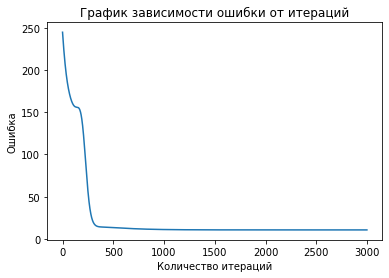

In [16]:
graph = pd.Series(errors)
plt.title("График зависимости ошибки от итераций")
plt.xlabel("Количество итераций")
plt.ylabel("Ошибка")
graph.plot.line()

In [17]:
molecule = Chem.MolFromMolFile("Conformer3D_CID_2244.sdf")
molecule = Chem.rdmolops.RemoveAllHs(molecule)
bonds = find_bonds(molecule)
# degrees = random_degrees(len(bonds))   
rotate_graph(molecule, bonds, degrees, False)
# coordinates_after_rotation = get_coordinates(molecule)
# Chem.Draw.IPythonConsole.drawMol3D(molecule)

def coordinates_method(bonds):
    """Покоординатный спуск"""
    count_bonds = len(bonds)
    molecule_after_r, buf_mols, derivative_mols = create_buffers_mol(count_bonds)
    h = 0.01
    new_degrees = random_degrees(count_bonds)
    if debug is True:
        print("новые рандомные углы: {}".format(new_degrees))
        print("рандомные углы, которые мы забываем: {}".format(degrees))
    #N = 3000
    prev_degrees = [0] * len(bonds)
    eps = 0.001
    for i in range(count_bonds - 1, -1, -1):
        while abs(prev_degrees[i] - new_degrees[i]) >= eps:
            copy_mol(molecule_after_r, molecule)
            if i == count_bonds - 1:
                copy_mol(molecule_after_r, buf_mols[i])
                copy_mol(molecule_after_r, derivative_mols[i])
            else:
                copy_mol(buf_mols[i+1], buf_mols[i])
                copy_mol(buf_mols[i+1], derivative_mols[i])
            
            one_angle_list = [0] * count_bonds
            one_angle_list[i] = -new_degrees[i]
            
            rotate_graph(buf_mols[i], bonds, one_angle_list, True)     
            coordinates_after_rotation_random_angle = get_coordinates(buf_mols[i])
            
            rotate_graph_derivative(derivative_mols[i], bonds, one_angle_list, True)
            new_coordinates_random = get_coordinates(derivative_mols[i])
            
            df_theta = find_df_theta(molecule, old_coordinates, coordinates_after_rotation_random_angle, new_coordinates_random, bonds, i)
            prev_degrees[i] = new_degrees[i]
            new_degrees[i] = (new_degrees[i] - h * df_theta) % 360
            one_angle_list[i] = -new_degrees[i]
            rotate_graph(molecule, bonds, one_angle_list, True)
        
            
        #N = 3000
    
    copy_mol(molecule_after_r, molecule)
    degrees_minus = list(map(lambda x: -x, new_degrees))
    rotate_graph(molecule, bonds, degrees_minus, True) 
    coord = get_coordinates(molecule)
    if debug is True:
        print("новые углы: {}".format(new_degrees))
        # print("sum err: {}".format(((old_coordinates - coord) ** 2).sum()))
    return ((old_coordinates - coord) ** 2).sum()

coordinates_method(bonds)
Chem.Draw.IPythonConsole.drawMol3D(molecule)

новые рандомные углы: [283.12, 283.86, 62.36]
рандомные углы, которые мы забываем: [283.68, 298.81, 64.49]
новые углы: [311.22239916431874, 308.8826370530071, 88.15291064618386]


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol